## Churn Prediction with Bank Turnover Dataset
Data Source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling/code

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

In [10]:
df = pd.read_csv(r'E:\Drive\gl\Months\R10_Dec_Intro_NN+DNN\project_external\Churn.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


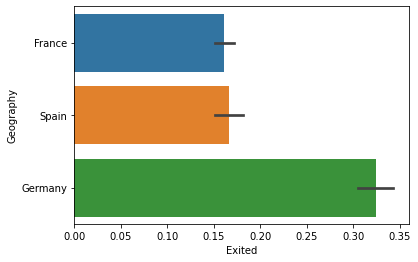

In [11]:
sns.barplot(x = df.Exited, y = df.Geography)

In [ ]:
df.drop('RowNumber', axis='columns', inplace=True)

In [15]:
ids = df[['CustomerId','Surname']]
X = df.iloc[:,2:-1] # extract relevant features for prediction 
y = df.Exited # target variable

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X.iloc[:, 2] = le.fit_transform(X.iloc[:, 2]) # encoding gender variable 

In [17]:
# one-hot encoding countries variable
geo_dum = pd.get_dummies(X.Geography)
X = pd.concat([X,geo_dum],axis = "columns")
X.drop('Geography', axis='columns', inplace=True)

Distribution of countries is imbalanced. We can tackle this problem using
undersampling, oversampling ,or using SMOTE. 
SMOTE is an oversampling technique that generates synthetic samples from the 
minority class. It is used to obtain a synthetically class-balanced or nearly 
class-balanced training set, which is then used to train the classifier.

In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 'minority')
X_sm, y_sm = smote.fit_sample(X,y)

In [20]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.2, random_state = 0, stratify = y_sm)

In [10]:
# scaling the variables
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Building the model

In [11]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

In [14]:
NN_model = Sequential()
# input layer
NN_model.add(Dense(64, input_dim = X_train.shape[1], activation='relu'))
# hidden layers
NN_model.add(Dense(128, activation='relu'))
NN_model.add(Dense(128, activation='relu'))
NN_model.add(Dense(128, activation='relu'))
NN_model.add(Dense(1,activation = 'sigmoid'))

In [15]:
NN_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 42,305
Trainable params: 42,305
Non-trainable params: 0
_________________________________________________________________


In [16]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [17]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 10192 samples, validate on 2548 samples
Epoch 1/500
10192/10192 [==============================] - 9s 902us/step - loss: 0.4268 - accuracy: 0.7984 - val_loss: 0.3775 - val_accuracy: 0.8257
Epoch 2/500
10192/10192 [==============================] - 7s 643us/step - loss: 0.3549 - accuracy: 0.8367 - val_loss: 0.3314 - val_accuracy: 0.8595
Epoch 3/500
10192/10192 [==============================] - 7s 729us/step - loss: 0.3359 - accuracy: 0.8472 - val_loss: 0.3213 - val_accuracy: 0.8571
Epoch 4/500
10192/10192 [==============================] - 7s 731us/step - loss: 0.3290 - accuracy: 0.8522 - val_loss: 0.3302 - val_accuracy: 0.8544
Epoch 5/500
10192/10192 [==============================] - 7s 705us/step - loss: 0.3214 - accuracy: 0.8546 - val_loss: 0.3092 - val_accuracy: 0.8709
Epoch 6/500
10192/10192 [==============================] - 7s 689us/step - loss: 0.3160 - accuracy: 0.8587 - val_loss: 0.3081 - val_accuracy: 0.8705
Epoch 7/500
10192/10192 [==============================] 

In [32]:
y_pred = NN_model.predict(X_test)

predictions = []
for i in y_pred:
    if(i>0.5):
        predictions.append(1)
    else:
        predictions.append(0)

In [30]:
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, predictions)
print("Accuracy score:",accuracy_score(y_test, predictions))
conf = pd.DataFrame(cm)
conf.index=['Actual_0','Actual_1']
conf.columns=['Predicted_0','Predicted_1']
conf

Accuracy score: 0.8512241054613936


,Predicted_0,Predicted_1
Actual_0,1369,224
Actual_1,250,1343


In [33]:
# Classification report 
from sklearn.metrics import classification_report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1593
           1       0.86      0.84      0.85      1593

    accuracy                           0.85      3186
   macro avg       0.85      0.85      0.85      3186
weighted avg       0.85      0.85      0.85      3186

